# Predict the price a supplier will quote for a given tube assembly.

In [1]:
!kaggle competitions download -c caterpillar-tube-pricing

  0%|                                                | 0.00/225k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 225k/225k [00:00<00:00, 12.1MB/s]
  0%|                                                | 0.00/794k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 794k/794k [00:00<00:00, 14.9MB/s]


In [2]:
!ls

LICENSE                             module2-gradient-boosting
README.md                           module3-hyperparameter-optimization
Untitled.ipynb                      module4-partial-dependence-plots
data.zip                            sample_submission.csv
module1-log-linear-regression


In [3]:
%%bash
if ls *.zip
then
    for z in *.zip
    do
        unzip "$z"
        rm "$z"
    done
    for c in *.csv
    do
        chmod +rwx "$c"
    done
    if ! test -d csvs
    then
        mkdir csvs
    fi
    mv *.csv csvs/
fi

data.zip
Archive:  data.zip
   creating: competition_data/
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv  
  inflating: competition_data/type_connection.

In [7]:
!ls competition_data

bill_of_materials.csv comp_other.csv        test_set.csv
comp_adaptor.csv      comp_sleeve.csv       train_set.csv
comp_boss.csv         comp_straight.csv     tube.csv
comp_elbow.csv        comp_tee.csv          tube_end_form.csv
comp_float.csv        comp_threaded.csv     type_component.csv
comp_hfl.csv          components.csv        type_connection.csv
comp_nut.csv          specs.csv             type_end_form.csv


In [8]:
import pandas as pd

In [10]:
test = pd.read_csv('competition_data/test_set.csv')
train = pd.read_csv('competition_data/train_set.csv')

In [13]:
train.shape, test.shape

((30213, 8), (30235, 8))

In [15]:
train.describe(exclude='number')

,tube_assembly_id,supplier,quote_date,bracket_pricing
count,30213,30213,30213,30213
unique,8855,57,1781,2
top,TA-04788,S-0066,2013-10-01,Yes
freq,14,20553,2877,26283


In [16]:
train.describe(include='number')

,annual_usage,min_order_quantity,quantity,cost
count,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317
std,1590.331872,12.742776,70.761392,28.663200
min,0.000000,0.000000,1.000000,0.503553
25%,0.000000,0.000000,2.000000,3.878190
50%,0.000000,0.000000,10.000000,6.521146
75%,2.000000,0.000000,40.000000,13.431781
max,150000.000000,535.000000,2500.000000,1000.000000


In [18]:
given = 'tube_assembly_id'
target = 'cost'

## Checking for Test/Train split

WE CHECK TO SEE IF THERE IS A SPECIFIC DIFFERENCE BETWEEN OUR TEST AND TRAINING DATA

In [19]:
trainTubes = train[given].unique()
testTubes = test[given].unique()
set(trainTubes) & set(testTubes)

set()

WE FIND THAT THERE IS, THEY DO NOT CONTAIN ANY OF THE SAME ASSEMBLY TUBE MODELS, SO WE SPLIT TRAIN IN VAL THE SAME WAY. TRAIN AND VAL SHOULD HAVE NO ASSEMBLY TUBE MODELS IN COMMON.

In [22]:
from sklearn.model_selection import train_test_split as tts

trainTubes, valTubes = tts(trainTubes)

In [26]:
val = train[train[given].isin(valTubes)]
train = train[train[given].isin(trainTubes)]

In [27]:
train.shape, val.shape, test.shape

((22704, 8), (7509, 8), (30235, 8))

In [29]:
set(train[given].unique()) & set(val[given].unique())

set()

## How we will judge our Model:

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Preparing Data

In [32]:
val_y = val[target]
val_x = val.drop(target, axis=1)

train_y = train[target]
train_x = train.drop(target, axis=1)

## Baseline Model

In [51]:
from sklearn.linear_model import LinearRegression

features = train_x.select_dtypes(include='number')

model = LinearRegression()
model.fit(features, train_y)


val_pred = model.predict(val_x.select_dtypes(include='number'))
rmsle(val_y, np.abs(val_pred))

0.9643069138336409

## Baseline Model 2

In [55]:
from sklearn.ensemble import RandomForestRegressor

features = train_x.select_dtypes(include='number')

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(features, train_y)


val_pred = model.predict(val_x.select_dtypes(include='number'))
rmsle(val_y, val_pred)

0.5824414964525465

## Mitigating Outliers

In [70]:
import seaborn as sns

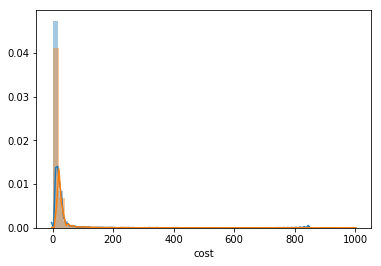

In [64]:
%matplotlib inline

sns.distplot(val_y)
sns.distplot(train_y)

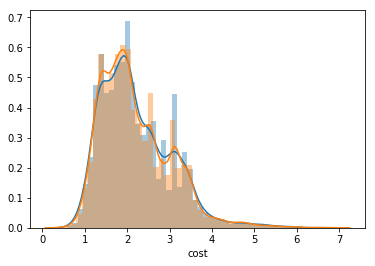

In [69]:
train_y_log = np.log1p(train_y)
val_y_log = np.log1p(val_y)

%matplotlib inline

sns.distplot(val_y_log)
sns.distplot(train_y_log)

## Baseline Model 3

In [73]:
from sklearn.ensemble import RandomForestRegressor

features = train_x.select_dtypes(include='number')

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(features, train_y_log)


val_pred_log = model.predict(val_x.select_dtypes(include='number'))
val_pred = np.expm1(val_pred_log)
rmsle(val_y, val_pred)

0.5362689465081522